In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import matplotlib.patches as mpatches
import cartopy
from datetime import timedelta as delta
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import xarray as xr
from os import environ
import matplotlib.animation as animation
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_data(rmsdvel):
    T = {}
    T['name'] = 'skimrmsdvel_asfield_%.2dcms.nc' %rmsdvel
    pfile = xr.open_dataset('/scratch/evansebille/%s' % T['name'], decode_cf=True)
    T['lon'] = np.ma.filled(pfile.variables['lon'], np.nan)
    T['lat'] = np.ma.filled(pfile.variables['lat'], np.nan)
    T['time'] = np.ma.filled(pfile.variables['time'], np.nan)
    return T

rmsdvels = [0, 5, 7, 10, 15, 20, 30]
D = {}
for rmsdvel in rmsdvels:
    D[rmsdvel] = load_data(rmsdvel)

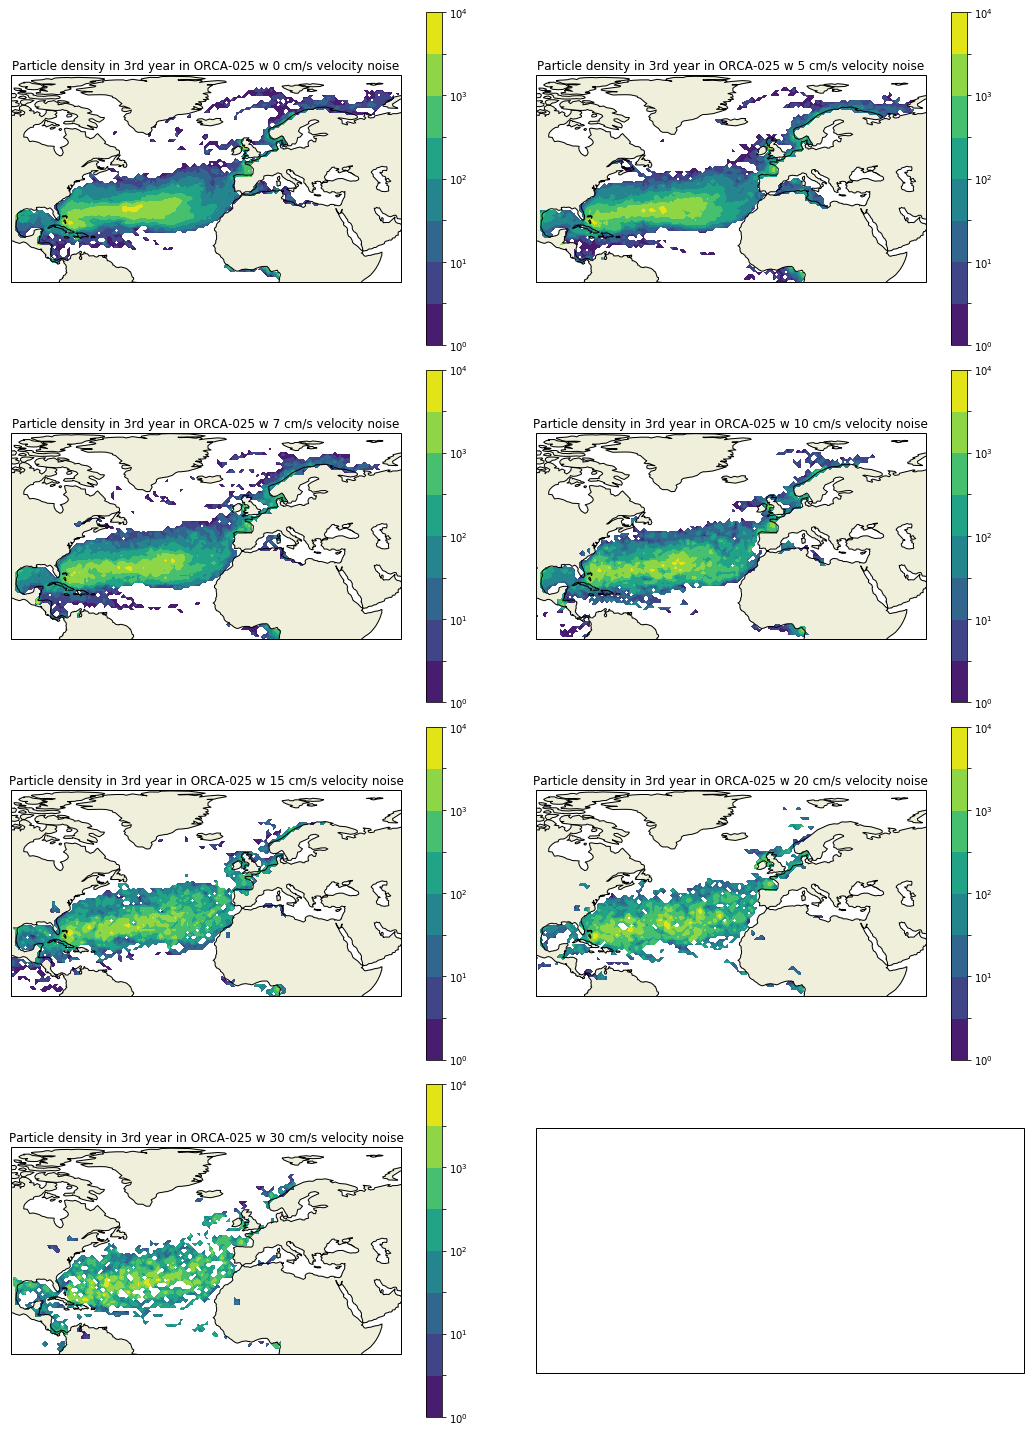

In [4]:
from matplotlib import colors
pylab.rcParams['figure.figsize'] = (15, 20)

projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(4, 2, subplot_kw={'projection': projection})
if len(D) == 1:
    ax = [ax]

for i, rmsd in enumerate(rmsdvels):
    ai = (i/2, i%2)
    T = D[rmsd]
    ax[ai].coastlines()
    ax[ai].add_feature(cartopy.feature.LAND)

    bins = [np.arange(260, 420, 1), np.arange(0, 85, 1)]
    lons = T['lon'][:, -73:-1]
    lats = T['lat'][:, -73:-1]
    D[rmsd]['H'], xe, ye = np.histogram2d(lons[~np.isnan(lons)], lats[~np.isnan(lats)], bins=bins)
    xb = (xe[1:] + xe[:-1])/2
    yb = (ye[1:] + ye[:-1])/2

    levels = [10**x for x in np.arange(0, 4.5, 0.5)]
    co = ax[ai].contourf(xb, yb, D[rmsd]['H'].T, levels=levels, transform=cartopy.crs.PlateCarree(), norm=colors.LogNorm())
    ax[ai].set_extent([bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], crs=cartopy.crs.PlateCarree())
    ax[ai].set_title('Particle density in 3rd year in ORCA-025 w %d cm/s velocity noise' % rmsd)
    fig.colorbar(co, ax=ax[ai])

# cbaxes = fig.add_axes([0.1, 0.05, 0.8, 0.03]) 
# cb = plt.colorbar(co, orientation="horizontal", cax = cbaxes)

plt.tight_layout()
savefig('histogram.pdf')

20
30


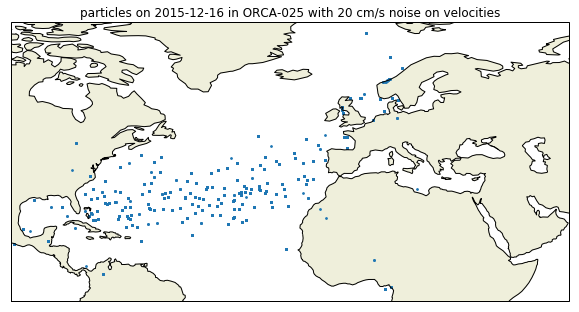

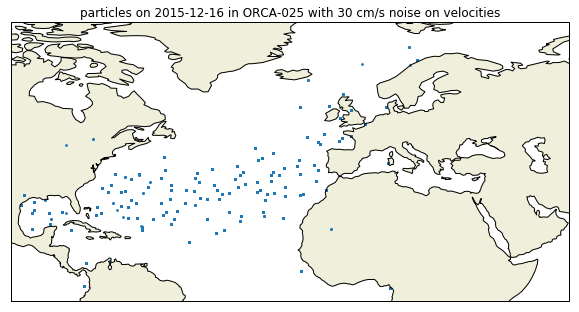

In [15]:
pylab.rcParams['figure.figsize'] = (10, 7)
projection = cartopy.crs.PlateCarree()

rmsdvels = [20, 30]
for i, rmsd in enumerate(rmsdvels):
    print(rmsd)
    T = D[rmsd]
    fig, ax = plt.subplots(1, 1,subplot_kw={'projection': projection})
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND)

    plottimes = np.arange(np.min(T['time']), np.max(T['time']), dtype='datetime64[5D]')

    b = np.where(np.logical_and(T['time'] >= plottimes[0], T['time'] < plottimes[1]))
    scat = ax.scatter(T['lon'][b], T['lat'][b], s=3, transform=cartopy.crs.Geodetic())
    ax.set_extent([-100, 60, 0, 80], crs=cartopy.crs.PlateCarree())

    ttl = ax.set_title('particles on ' + str(plottimes[0])+' in ORCA-025 with %d cm/s noise on velocities' % rmsd)
    frames = np.arange(0, len(plottimes)-1)

    def animate(t):
        b = np.where(np.logical_and(T['time'] >= plottimes[t], T['time'] < plottimes[t+1]))
        scat.set_offsets(np.vstack((T['lon'][b], T['lat'][b])).transpose())
        ttl.set_text('particles on ' + str(plottimes[t]) +' in ORCA-025 with %d cm/s noise on velocities' % rmsd)
        return scat,

    ax.set_extent([-100, 60, 0, 80], crs=cartopy.crs.PlateCarree())
    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
    anim
    anim.save(T['name'].replace('.nc', '.gif'), writer='imagemagick', fps=10)

In [ ]:
D[99]['name'].replace('.nc', '.gif')

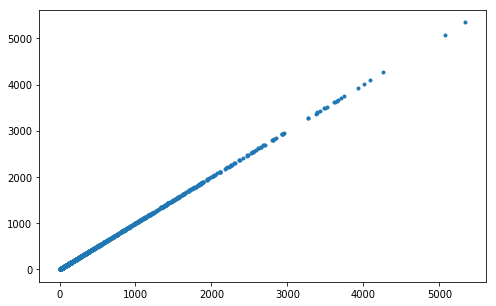

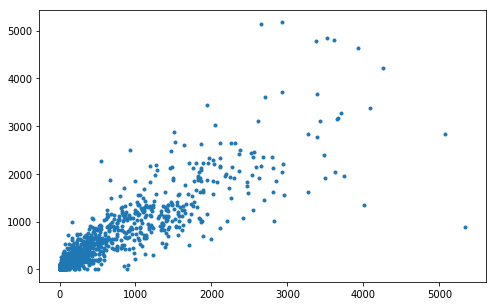

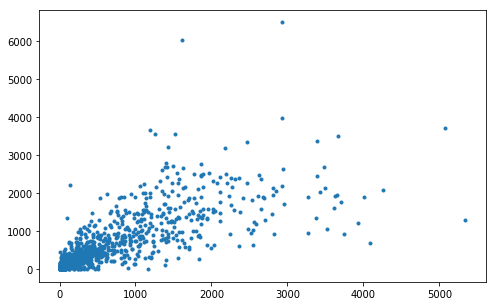

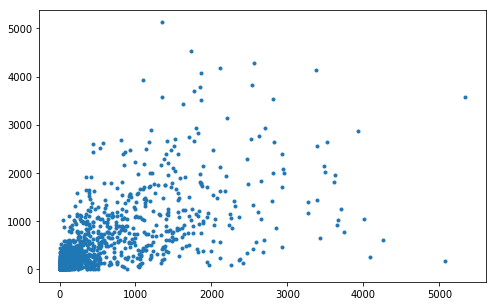

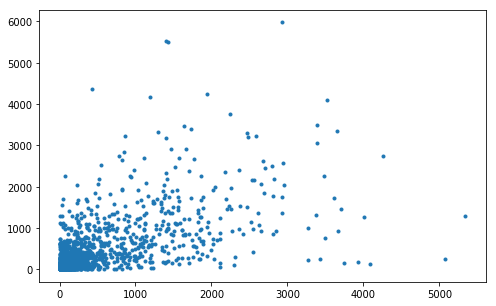

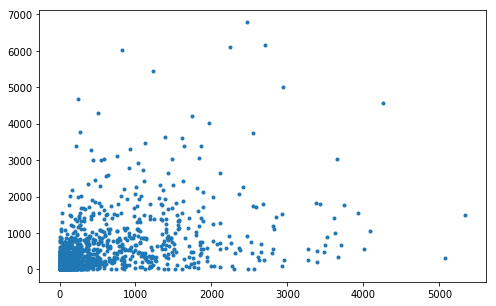

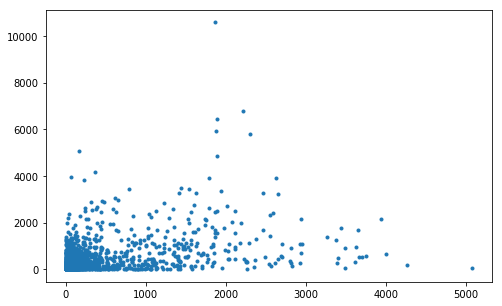

In [39]:
import scipy.stats
pylab.rcParams['figure.figsize'] = (8, 5)

rmsd = 15
R = []
for rmsd in rmsdvels:
    I= np.where(np.logical_and(D[0]['H'].flatten()>0, D[rmsd]['H'].flatten()>0))[0]
    plt.plot(D[0]['H'].flatten()[I], D[rmsd]['H'].flatten()[I],'.')
    a = scipy.stats.spearmanr(D[0]['H'].flatten()[I], D[rmsd]['H'].flatten()[I])
    R.append(a[0])

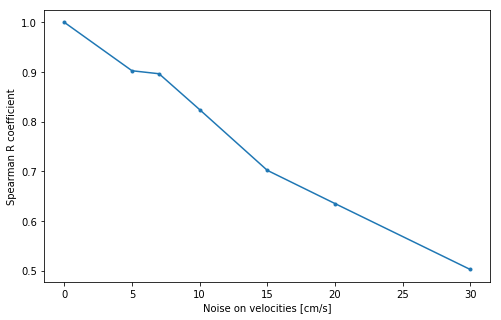

In [44]:
plt.plot(rmsdvels, R, '.-')
plt.xlabel('Noise on velocities [cm/s]')
plt.ylabel('Spearman R coefficient')
savefig('spearmanR.pdf')